# Using CNN for dolphin whistle classification

Import relevant packages. Set up the virtual environment as specified in the README file to avoid "dependency-hell".

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models  # For specifying the type of layer (Dense)

# from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from pathlib import Path


In [ ]:
# os.chdir('D:/DolphinVIPFiles/DolphinVIPFiles/images_second_run')
# os.getcwd()

# Generate Training, Validation and Test Datasets
Before running the following cell, change the relative paths to the folders on your machine.
(Also make sure you have the data on your machine)

In [3]:
TRAINING_DATA_DIR = Path("model_test_train/train")
TEST_DATA_DIR = Path("model_test_train/test")

In [4]:
# These can be configured differently
X, Y = 413, 202
IMAGE_SHAPE = (Y, X) # (row, col) format for imshow and (height, width) for ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=0.20
)  # https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="training", shuffle=True, target_size=IMAGE_SHAPE
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="validation", shuffle=True, target_size=IMAGE_SHAPE
)

test_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TEST_DATA_DIR, shuffle=True, target_size=IMAGE_SHAPE
)

FileNotFoundError: [Errno 2] No such file or directory: 'model_test_train/train'

# Visualise the inputs

In [1]:
# Visualise the datasets
images = iter(train_generator[0][0])
labels = iter(train_generator[0][1])

classes = dict((v, k) for k, v in (train_generator.class_indices).items())

fig, ax = plt.subplots(2, 2, figsize=(7, 5))
for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])
    sp.imshow(next(images), aspect="auto")
    label_index = np.where(next(labels) == 1)[0][0]
    sp.set_xlabel(classes.get(label_index))
plt.show()
fig.savefig("image.pdf")
print("Shape of images: ", train_generator[0][0].shape)

NameError: name 'train_generator' is not defined

# Build a CNN model and stack layers

In [15]:
model = models.Sequential()
KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (X, Y, 3)

model.add(layers.Conv2D(16, KERNEL_SIZE, activation="relu", input_shape=INPUT_SHAPE))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(BatchNormalization())

# Adding fully connected layers
model.add(layers.Flatten())  # From a 3D tensor to a 1D
model.add(layers.Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(layers.Dense(3, activation="softmax"))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 411, 200, 16)      448       
                                                                 
 batch_normalization_8 (Batc  (None, 411, 200, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 205, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 203, 98, 16)       2320      
                                                                 
 batch_normalization_9 (Batc  (None, 203, 98, 16)      64        
 hNormalization)                                                 
                                                      

# Train the model

In [16]:
# Initialising the model
print("[INFO] compiling model...")
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)  # can play with different parameters

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
NUM_EPOCHS = 3
es = EarlyStopping("val_loss", mode="min", verbose=1, patience=5)

# Training the network
print("[INFO] training network for {} epochs...".format(NUM_EPOCHS))
history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=NUM_EPOCHS,
    callbacks=[es],
)


[INFO] compiling model...
[INFO] training network for 3 epochs...
Epoch 1/3
60/60 [==============================] - 61s 992ms/step - loss: 1.0189 - accuracy: 0.5958 - val_loss: 1.0836 - val_accuracy: 0.3625
Epoch 2/3
60/60 [==============================] - 60s 1s/step - loss: 0.4904 - accuracy: 0.8365 - val_loss: 1.1795 - val_accuracy: 0.3354
Epoch 3/3
60/60 [==============================] - 60s 1s/step - loss: 0.1674 - accuracy: 0.9609 - val_loss: 1.6505 - val_accuracy: 0.3354


# Evaluating the Network

**Validation and training accuracy:**

[INFO] evaluating network...
19/19 - 6s - loss: 1.6827 - accuracy: 0.3333 - 6s/epoch - 300ms/step
----- Evaluation Summary statistics -----
Test accuracy =  0.3333333432674408
Test loss =  1.6827266216278076


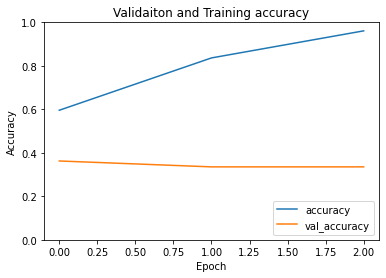

In [17]:
# Evalutate the network - use validation set
print("[INFO] evaluating network...")

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Validation and Training accuracy")
plt.legend(loc="lower right")

test_loss, test_acc = model.evaluate(
    test_generator, verbose=2
)  # Check the return values for this

# SUMMARY STATISTICS
print("----- Evaluation Summary statistics -----")
print("Test accuracy = ", test_acc)
print("Test loss = ", test_loss)


**Validation and Training Loss:**

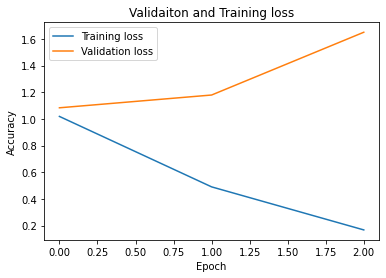

In [18]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Validation and Training loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.ylim([0, 1])
plt.legend()


In [19]:
print("[INFO] Predict with network...")
model = keras.models.load_model("10_02_2022_basic_classifier.model")
test_generator.reset()
test_labels = test_generator.classes
array_of_class_names = np.array(list(classes.values()))
y_hat = model.predict(test_generator)
print(
    classification_report(
        test_labels, y_hat.argmax(axis=1), target_names=array_of_class_names
    )
)


[INFO] Predict with network...
              precision    recall  f1-score   support

  bottlenose       0.33      0.96      0.49       200
      common       0.40      0.04      0.07       200
melon-headed       1.00      0.01      0.01       200

    accuracy                           0.34       600
   macro avg       0.58      0.33      0.19       600
weighted avg       0.58      0.34      0.19       600



# Save or load model

In [ ]:
# Save the trained model -> could save just the weights or the entire architecture
model.save('10_02_2022_basic_classifier.model')
# loaded_model = keras.models.load_model('/content/drive/MyDrive/16_03_2021_basic_classifier.model')